In [2]:
from transformers import AutoModel, AutoTokenizer
import torch

# Placeholder for the actual ChemBERTa model name
model_name = "seyonec/ChemBERTa-zinc-base-v1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(DEVICE)



In [3]:
tokenizer.vocab

{'&': 10,
 '9': 29,
 'sc': 296,
 'CSCCCNC': 619,
 '@](': 354,
 '¡': 99,
 'NNS': 547,
 '«': 109,
 'NCc': 302,
 'CCOCCO': 559,
 'OCCCCC': 661,
 'CSCCO': 496,
 'ncc': 298,
 'CH': 680,
 '-])\\': 742,
 'CCCBr': 729,
 'î': 175,
 '-])[': 372,
 'CCOCC': 315,
 'ccnn': 392,
 'COCOc': 669,
 'CCSS': 707,
 'À': 129,
 'CCSCCOC': 708,
 'IC': 716,
 'ł': 259,
 'COCCNCc': 759,
 'ncon': 532,
 '-])(': 571,
 ')(=': 287,
 'CCONC': 583,
 'COP': 647,
 'OCCCC': 512,
 'Í': 142,
 'cnsn': 652,
 'NOc': 718,
 'SH': 723,
 'SCCCO': 725,
 'w': 91,
 'ncccn': 391,
 'ě': 220,
 'CO': 275,
 'OCCOCCOCCO': 653,
 'Ü': 157,
 '6': 26,
 'ĵ': 246,
 'nsc': 441,
 'NH': 273,
 'OCN': 601,
 '(=[': 467,
 'CCCl': 479,
 'cc': 261,
 'Ļ': 252,
 '<pad>': 1,
 'OCCOCCOCCOCCO': 766,
 'ç': 168,
 '13': 435,
 'Ā': 193,
 'COCCCn': 566,
 'COCc': 386,
 'CCSCC': 399,
 'ª': 108,
 '-': 17,
 'NCCCn': 447,
 'CCCCOCc': 738,
 'COCCNS': 623,
 'ċ': 204,
 'İ': 241,
 'cnnn': 421,
 'Ę': 217,
 ']': 65,
 'Clc': 418,
 'NOC': 584,
 'û': 188,
 'ð': 177,
 'Ĵ': 245,
 

In [4]:
from tqdm import tqdm

def get_features(file):

    smilies=[]
    labels=[]
    with open(file, 'r') as f:
       
        lines = f.readlines()
        for line in lines:
            line=line.strip()
            line = line.split('\t')
            smilies.append(line[0])
            labels.append(line[2])

    #convert labels to int
    labels = [int(i) for i in labels]

    embeddings_list = []
    for smiles_list in tqdm(smilies):
        # Tokenize SMILES
        inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")

        # Move inputs to the same device as model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Extract embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # The output embeddings can be accessed with outputs.last_hidden_state or outputs.pooler_output
        # depending on what we consider as the embedding.

        # For instance, to get the embeddings for the entire sequence, we might average the last hidden states
        embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings_list.append(embeddings)

    import numpy as np
    from sklearn.utils import resample

    # Assuming data_list is our list of graph objects and labels_array is a NumPy array of labels
    data_list = embeddings_list # our list of graph objects
    labels_array = np.array(labels)  # our NumPy array of labels

    # Identify indices of majority and minority classes
    majority_indices = np.where(labels_array == 0)[0]
    minority_indices = np.where(labels_array == 1)[0]

    # Perform undersampling
    # Here, we'll downsample the majority class to match the number of samples in the minority class
    undersampled_majority_indices = resample(majority_indices,
                                            replace=False,  # no replacement
                                            n_samples=len(minority_indices),  # match minority class size
                                            random_state=123)  # reproducible results

    # Combine the undersampled majority indices with the minority indices
    undersampled_indices = np.concatenate([undersampled_majority_indices, minority_indices])

    # Use these indices to create our new balanced dataset
    undersampled_data_list = [data_list[i] for i in undersampled_indices]
    undersampled_labels_array = labels_array[undersampled_indices]

    # Now, undersampled_data_list and undersampled_labels_array are our balanced dataset

    #create a folder to save the features and labels
    import os
    if not os.path.exists(file.split('/')[-1].split('.')[0]):
        os.makedirs(file.split('/')[-1].split('.')[0])
    
    #save the features and labels
    torch.save(undersampled_data_list, file.split('/')[-1].split('.')[0]+'/train_feature_bert.pt')
    torch.save(undersampled_labels_array, file.split('/')[-1].split('.')[0]+'/train_labels_bert.pt')
    print('saved features and labels for', file.split('/')[-1].split('.')[0])


In [51]:
import glob 
from tqdm import tqdm


files=glob.glob("./dataset/Seperated_dataset/*")


for file in files:
    get_features(file)
    print('done for', file)

100%|██████████| 8169/8169 [00:39<00:00, 207.56it/s]


saved features and labels for Seperated_dataset\nr-ahr
done for ./dataset/Seperated_dataset\nr-ahr.smiles


100%|██████████| 8599/8599 [00:40<00:00, 210.43it/s]


saved features and labels for Seperated_dataset\nr-ar-lbd
done for ./dataset/Seperated_dataset\nr-ar-lbd.smiles


100%|██████████| 9362/9362 [00:44<00:00, 208.09it/s]


saved features and labels for Seperated_dataset\nr-ar
done for ./dataset/Seperated_dataset\nr-ar.smiles


100%|██████████| 7226/7226 [00:34<00:00, 207.08it/s]


saved features and labels for Seperated_dataset\nr-aromatase
done for ./dataset/Seperated_dataset\nr-aromatase.smiles


100%|██████████| 8753/8753 [00:41<00:00, 209.60it/s]


saved features and labels for Seperated_dataset\nr-er-lbd
done for ./dataset/Seperated_dataset\nr-er-lbd.smiles


100%|██████████| 7697/7697 [00:36<00:00, 208.30it/s]


saved features and labels for Seperated_dataset\nr-er
done for ./dataset/Seperated_dataset\nr-er.smiles


100%|██████████| 8184/8184 [00:38<00:00, 211.08it/s]


saved features and labels for Seperated_dataset\nr-ppar-gamma
done for ./dataset/Seperated_dataset\nr-ppar-gamma.smiles


100%|██████████| 7167/7167 [00:34<00:00, 208.60it/s]


saved features and labels for Seperated_dataset\sr-are
done for ./dataset/Seperated_dataset\sr-are.smiles


100%|██████████| 9091/9091 [00:43<00:00, 209.20it/s]


saved features and labels for Seperated_dataset\sr-atad5
done for ./dataset/Seperated_dataset\sr-atad5.smiles


100%|██████████| 8150/8150 [00:39<00:00, 207.44it/s]


saved features and labels for Seperated_dataset\sr-hse
done for ./dataset/Seperated_dataset\sr-hse.smiles


100%|██████████| 7320/7320 [00:35<00:00, 207.39it/s]


saved features and labels for Seperated_dataset\sr-mmp
done for ./dataset/Seperated_dataset\sr-mmp.smiles


100%|██████████| 8634/8634 [00:41<00:00, 209.39it/s]

saved features and labels for Seperated_dataset\sr-p53
done for ./dataset/Seperated_dataset\sr-p53.smiles


./dataset/Seperated_dataset\nr-ahr.smiles


  0%|          | 0/8169 [00:00<?, ?it/s]

100%|██████████| 8169/8169 [00:31<00:00, 259.53it/s]


./dataset/Seperated_dataset\nr-ar-lbd.smiles


100%|██████████| 8599/8599 [00:32<00:00, 264.04it/s]


./dataset/Seperated_dataset\nr-ar.smiles


100%|██████████| 9362/9362 [00:35<00:00, 260.19it/s]


./dataset/Seperated_dataset\nr-aromatase.smiles


100%|██████████| 7226/7226 [00:30<00:00, 240.10it/s]


./dataset/Seperated_dataset\nr-er-lbd.smiles


100%|██████████| 8753/8753 [00:38<00:00, 227.36it/s]


./dataset/Seperated_dataset\nr-er.smiles


100%|██████████| 7697/7697 [00:32<00:00, 235.42it/s]


./dataset/Seperated_dataset\nr-ppar-gamma.smiles


100%|██████████| 8184/8184 [00:34<00:00, 235.29it/s]


./dataset/Seperated_dataset\sr-are.smiles


100%|██████████| 7167/7167 [00:30<00:00, 237.08it/s]


./dataset/Seperated_dataset\sr-atad5.smiles


100%|██████████| 9091/9091 [00:38<00:00, 236.70it/s]


./dataset/Seperated_dataset\sr-hse.smiles


100%|██████████| 8150/8150 [00:34<00:00, 238.77it/s]


./dataset/Seperated_dataset\sr-mmp.smiles


100%|██████████| 7320/7320 [00:31<00:00, 235.09it/s]


./dataset/Seperated_dataset\sr-p53.smiles


100%|██████████| 8634/8634 [00:36<00:00, 234.14it/s]


In [16]:
dataset_name="nr-ahr"
embeddings=torch.load(f'./Seperated_dataset/{dataset_name}/train_feature_bert.pt')
labels=torch.load(f'./Seperated_dataset/{dataset_name}/train_labels_bert.pt')


embeddings_test=torch.load(f'./Seperated_dataset/{dataset_name}/test_feature_bert.pt')   
labels_test=torch.load(f'./Seperated_dataset/{dataset_name}/test_labels_bert.pt')


# squish the embeddings
# embeddings = [i.squeeze() for i in embeddings]

In [11]:
sampled_embeddings[0].shape

(1, 768)

In [15]:
len(embeddings)

1900

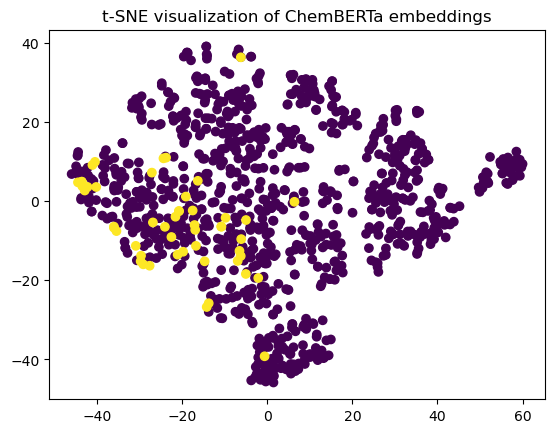

In [13]:
sampled_embeddings = embeddings[:1000]
sampled_labels = labels[:1000]

#perform tsn-e and plot

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)

sampled_embeddings = np.array([i[0].cpu().numpy() for i in sampled_embeddings])

# Perform t-SNE on the sampled embeddings
embeddings_2d = tsne.fit_transform(sampled_embeddings)

# Visualize the 2D embeddings

# Create a scatter plot

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=sampled_labels)
plt.title('t-SNE visualization of ChemBERTa embeddings')

plt.show()


In [17]:
from typing import Callable, Optional
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Dataset
from torch_geometric.nn import VGAE, GATConv, GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from typing import Any, List
import os
import os.path as osp
from copy import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pickle

import numpy as np

#empty cuda cache
torch.cuda.empty_cache()
#create a dataloader for the encoded data
class encoded_dataset(Dataset):
    def __init__(self, 
                 data: List[torch.Tensor],
                 labels: List[int],
                 root: str | None = None, 
                 transform: Callable[..., Any] | None = None, 
                 pre_transform: Callable[..., Any] | None = None, 
                 pre_filter: Callable[..., Any] | None = None, 
                 log: bool = True):
        super().__init__(root, transform, pre_transform, pre_filter, log)
        self.data = data
        self.labels = labels
        
    def len(self):
        return len(self.data)

    def get(self, idx):
        # Ensure that data and labels are torch.Tensors
        data_tensor = torch.Tensor(self.data[idx]) if isinstance(self.data[idx], np.ndarray) else self.data[idx]
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long) 
        # print(data_tensor)
        # print(label_tensor)
        return data_tensor, label_tensor


c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [18]:

#split the data into train and valid
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings,labels, test_size=0.1, random_state=42)

train_dataset=encoded_dataset(X_train,y_train)
test_dataset=encoded_dataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



test_final_dataset=encoded_dataset(embeddings_test,labels_test)
test_final_loader = DataLoader(test_final_dataset, batch_size=32, shuffle=True)


In [26]:
len(embeddings_test),len(labels_test)

(610, 610)

In [30]:
labels_test

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [23]:



import torch
import torch.nn as nn
import torch.nn.functional as F

# class ComplexEncodedClassifier(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(ComplexEncodedClassifier, self).__init__()
        
#         # Assuming the input shape is (batch_size, 1, 768) where 1 is the number of channels
#         self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)  # Adjusted in_channels to 1
#         self.bn1 = nn.BatchNorm1d(128)
#         self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm1d(256)
#         self.pool = nn.MaxPool1d(2)  # Downsample
        
#         # Adjust the input features for the first linear layer according to the output of conv and pool layers
#         self.fc1 = nn.Linear(256 * 192, 512)  # Adjusted the size
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, out_features)
        
#     def forward(self, x):
#         # Assuming x is of shape (batch_size, 1, 768)
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.pool(x)  # Adjust the shape in comments accordingly
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.pool(x)  # Further adjust the shape in comments
        
#         # Flatten before passing to the dense layer
#         x = x.view(x.size(0), -1)
        
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)  # No activation, assuming we're using BCEWithLogitsLoss or similar
        
#         return x

class EncodedClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(EncodedClassifier, self).__init__()

        # Define the MLP architecture with 5 layers as an example
        self.fc1 = nn.Linear(in_features, 1024)  # First layer
        self.fc2 = nn.Linear(1024,768)          # Second layer
        self.fc3 = nn.Linear(768,512)          # Third layer
        self.fc4 = nn.Linear(512,256)           # Fourth layer
        self.fc5 = nn.Linear(256,64)            # Fifth layer
        self.fc6 = nn.Linear(64, out_features)  # Output layer
        
        self.dropout = nn.Dropout(0.15)  # Dropout layer to prevent overfitting
        
    def forward(self, x):
        # Flatten the input in case it's not already flat
        x = x.view(x.size(0), -1)
        
        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # No activation here, assuming we're using BCEWithLogitsLoss or similar
        
        return x






#train the classifier

classifier =EncodedClassifier(768, 1).to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

epochs = 100

#calculate the accuracy and roc_auc_score for each epoch. Save the best model based on the roc_auc_score

from sklearn.metrics import accuracy_score, roc_auc_score

best_auc = 0

for epoch in range(epochs):
    classifier.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = classifier(data)
        loss = criterion(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    # print(f"Epoch {epoch} - Train Loss: {train_loss}")
    
    classifier.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_final_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = classifier(data)
            loss = criterion(output, target.unsqueeze(1).float())
            test_loss += loss.item() * data.size(0)
            y_true += target.cpu().numpy().tolist()
            y_pred += torch.sigmoid(output).cpu().numpy().tolist()
    test_loss = test_loss / len(test_final_loader.dataset)
    y_pred = [i[0] for i in y_pred]
    auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
    # print(f"Epoch {epoch} - Test Loss: {test_loss} - AUC: {auc} - Accuracy: {accuracy}")
    if auc > best_auc:
        print(f"Saving best model with AUC: {auc}")
        torch.save(
            classifier.state_dict(),
            "./Seperated_dataset/nr-ahr/best_classifier_bert.pt"
        )
        best_auc = auc

#load the best classifier

Saving best model with AUC: 0.8376316930690544
Saving best model with AUC: 0.8385500369888523
Saving best model with AUC: 0.8456672023672867
Saving best model with AUC: 0.8510242085661079
Saving best model with AUC: 0.8542129027320732
Saving best model with AUC: 0.8549016606719215
Saving best model with AUC: 0.8661003545827913


In [24]:

#import precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#load the best classifier
classifier = EncodedClassifier(768, 1).to(DEVICE)
classifier.load_state_dict(torch.load("./Seperated_dataset/nr-ahr/best_classifier_bert.pt"))



classifier.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_final_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = classifier(data)
        y_true += target.cpu().numpy().tolist()
        y_pred += torch.sigmoid(output).cpu().numpy().tolist()

y_pred = [i[0] for i in y_pred]
auc = roc_auc_score(y_true, y_pred)
accuracy = accuracy_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
precision = precision_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
recall = recall_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])


print(f"AUC: {auc} - Accuracy: {accuracy} - Precision: {precision} - Recall: {recall}")

AUC: 0.8661003545827913 - Accuracy: 0.8098360655737705 - Precision: 0.35947712418300654 - Recall: 0.7534246575342466


In [62]:
y_pred_gae=np.load('./Seperated_dataset/nr-ahr/pred_gae.npy')

In [63]:
# average the predictions

y_pred_avg = [(y_pred[i]+y_pred_gae[i])/2 for i in range(len(y_pred))]
auc = roc_auc_score(y_true, y_pred_avg)
accuracy = accuracy_score(y_true, [1 if i > 0.5 else 0 for i in y_pred_avg])
precision = precision_score(y_true, [1 if i > 0.5 else 0 for i in y_pred_avg])
recall = recall_score(y_true, [1 if i > 0.5 else 0 for i in y_pred_avg])

print(f"AUC: {auc} - Accuracy: {accuracy} - Precision: {precision} - Recall: {recall}")

AUC: 0.8338888888888889 - Accuracy: 0.7684210526315789 - Precision: 0.85 - Recall: 0.68


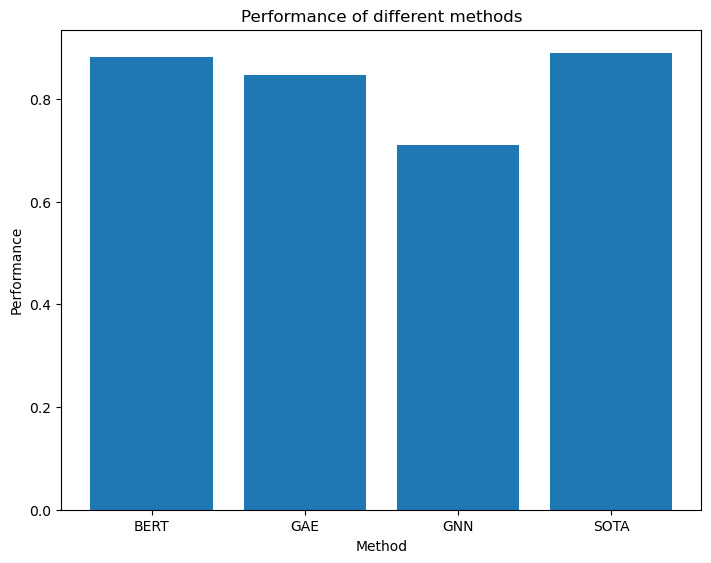

In [66]:
Performances=[0.881,0.847,0.71,0.89]
method_names=['BERT','GAE','GNN','SOTA']


import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

#give headings to each of the plots
ax.set_ylabel('Performance')
ax.set_xlabel('Method')
ax.set_title('Performance of different methods')

#plot the bar chart

ax.bar(method_names,Performances)

#display the plot




plt.show()
